In [22]:
#run once!!
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import datetime
import re
from collections import defaultdict
from heapq import *
# from google.colab import drive
import math
import numpy as np
import pickle
import requests
import os
today=datetime.date.today()
path=f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}'
if not os.path.exists(path):
    os.makedirs(path)

In [23]:
#関数パート
def pathtovalleyfree5(inPath,node):
  vtypestr=""
  path2=inPath+[node]
  # print(inPath,path2,"node",node)
  for i in range(len(path2)):
    try:
      vtypestr+=str(G.edges[[path2[i],path2[i+1]]]["vtype"])  
      # print("try")                    #エッジのｐｐｃｐｐｃの順番の文字列
    except:
      # print("exc")
      pass

  # print("vtystr:",vtypestr)
  if vtypestr.count("6")>1 or re.findall(".*4.*2.*",vtypestr) or re.findall(".*4.*6.*",vtypestr) or re.findall(".*6.*2.*",vtypestr):  #不可能な文字列だと
    return False 
  else:
    return True


def gdijkstra5(f):
    q, seen, mins = [(0,f,[])], set(), {f: [0,[f]]}
    seen.add(f)
    for v2 in list(G.neighbors(f)):
      c =G.edges[f,v2]["weight"]
      mins[v2] = [c,[f,v2]]
      heappush(q, (c, v2, [f]))
    while q:
      (cost,v1,path) = heappop(q)
      # print(cost,v1,path, q, seen, mins)
      if v1 not in seen:
          seen.add(v1)
          path3=path+[v1]
          # if len(mins)==G.number_of_nodes(): return sorted(mins)
          for v2 in list(G.neighbors(v1)):
              c =G.edges[v1,v2]["weight2"]
              # print("v1:",v1,"v2:",v2,c)
              if v2 in seen : continue
              prev = mins.get(v2, None)
              next = cost + c
              if (prev is None or next < prev[0]) and pathtovalleyfree5(path3,v2):
                  mins[v2] = [next,path3+[v2]]
                  heappush(q, (next, v2, path3))
    del mins[f]
    return mins

#導入率を受けとり、２パターンの導入率におけるダメージ量の属性を初期化、１パターン非導入２パターン非導入１２パたRPKI色
def dep_sta(rate):
  dep_AS=random.sample(node_list,int(len(node_list)*rate/100)) #ある導入率をもとにランダムに選出
  ndep_AS=[i for i in node_list if i not in dep_AS]
  
  top_dep_AS=[pair[0] for pair in sorted(list(G.degree()),reverse=True,key=lambda x:x[1])[0:int(len(node_list)*rate/100)]] #ある導入率をもとに次数順に選出
  top_ndep_AS=[i for i in node_list if i not in top_dep_AS]

  for AS in ndep_AS:
    G.nodes[AS]["rpki0"]="r"
    G.nodes[AS]["Cost0"]=0
    G.nodes[AS]['damage0']=0
  for AS in dep_AS:
    G.nodes[AS]["rpki0"]="b"
    G.nodes[AS]["Cost0"]= G.nodes[AS]['Costfixed']
    G.nodes[AS]['damage0']=0
  for AS in top_dep_AS:
    G.nodes[AS]["rpki1"]="b"
    G.nodes[AS]["Cost1"]=G.nodes[AS]['Costfixed']
    G.nodes[AS]['damage1']=0
  for AS in top_ndep_AS:
    G.nodes[AS]["rpki1"]="r"
    G.nodes[AS]["Cost1"]=0
    G.nodes[AS]['damage1']=0
   
  return (ndep_AS,top_ndep_AS,[G.nodes[AS]['rpki0'] for AS in node_list],[G.nodes[AS]['rpki1'] for AS in node_list],dep_AS,top_dep_AS) #ランダム選出AS、次数順選出AS、ランダム順色、次数順色

#導入率を受け取り、ダメージを受けるASを計算して、２パターンのダメージ量を返す
def ratio_damage(ratio):
  ndep=dep_sta(ratio)
  for i in [0,1]:
    #中間ASが導入していないことによりダメージを受けるODのペア
    damage_add=set()
    #0:ランダムにチョイスする 1:次数順に導入する
    for AS in ndep[i]:
      try:
        for od_pair_bymidAS in AS_OD_dic[AS]:
          damage_add.add(od_pair_bymidAS)
        for od_pair_byoriginal in OD_pair[AS]:
          damage_add.add(od_pair_byoriginal)
      except:
        pass
    for (origin,destination) in damage_add:
      G.nodes[origin]['damage'+str(i)]+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)
      G.nodes[destination]['damage'+str(i)]+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)

  return ([G.nodes[AS]['nodepDamage']-G.nodes[AS]['Brandparam']*G.nodes[AS]['damage0']- G.nodes[AS]['Cost0'] for AS in node_list],[G.nodes[AS]['nodepDamage']- G.nodes[AS]['Brandparam']*G.nodes[AS]['damage1'] - G.nodes[AS]['Cost1']for AS in node_list],ndep)#ランダム導入時の損得、次数導入時の損得、上記関数



#ASノード番号を受け取り、それだけ導入にしてそのASの損益値を得る
def ndepAS_benefitorloss(nodenum,ndeplist):
  for AS in node_list:
    G.nodes[AS]['hdamage']=0
  nl=copy.deepcopy(ndeplist)
  nl.remove(nodenum)
  hdamage_add=set()
  for AS in nl:
    try:
      for od_pair_bymidAS in AS_OD_dic[AS]:
        hdamage_add.add(od_pair_bymidAS)
      for od_pair_byoriginal in OD_pair[AS]:
        hdamage_add.add(od_pair_byoriginal)
    except:
      pass
  for (origin,destination) in hdamage_add:
    G.nodes[origin]['hdamage']+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)
    G.nodes[destination]['hdamage']+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)
  return G.nodes[nodenum]['nodepDamage']-G.nodes[nodenum]['hdamage']*G.nodes[AS]['Brandparam']



def inRate_toenddeprate(RorD,rate,cost):
  dep_rate=[]
  damage_list=ratio_damage(rate)

  if RorD=='0':
    nodeployASlist=damage_list[2][0]
    deployASlist=damage_list[2][4]
  if RorD=="1":
    nodeployASlist=damage_list[2][1]
    deployASlist=damage_list[2][5]

  benefitorlosslist=[G.nodes[AS]['nodepDamage']-G.nodes[AS][f'damage{RorD}']*G.nodes[AS]['Brandparam']- G.nodes[AS][f'Cost{RorD}'] for AS in node_list]
  
  while int(len([node for node in node_list if G.nodes[node][f'rpki{RorD}']=='b'])/len(node_list)) !=1: 
#     print('benefitorlosslist',benefitorlosslist)
    fN_tD_removelist=[] #導入、非導入に動くASのリスト
    for randomndepnode in nodeployASlist: #ランダム導入で導入していないAS 
      G.nodes[randomndepnode][f"rpki{RorD}"]="r"
      G.nodes[randomndepnode][f"Cost{RorD}"]=0
      G.nodes[randomndepnode][f'damage{RorD}']=0
      G.nodes[randomndepnode]['ifASChangedVal']=ndepAS_benefitorloss(randomndepnode,nodeployASlist)
      if benefitorlosslist[node_list.index(randomndepnode)] < G.nodes[randomndepnode]['ifASChangedVal'] - G.nodes[randomndepnode]['Costfixed']:  
        fN_tD_removelist.append(randomndepnode)
#         print('ASischanged=',randomndepnode)
#         print(benefitorlosslist[node_list.index(randomndepnode)],'<', G.nodes[randomndepnode]['ifASChangedVal'],'-' ,G.nodes[randomndepnode]['Costfixed'])

    for randomdepnode in deployASlist: #ランダム導入で導入AS 
      G.nodes[randomdepnode][f"rpki{RorD}"]="b"
      G.nodes[randomdepnode][f"Cost{RorD}"]=G.nodes[randomdepnode]['Costfixed']
      G.nodes[randomdepnode][f'damage{RorD}']=0
      G.nodes[randomdepnode]['ifASChangedVal']=0
        
    damage_add=set()
    for AS in nodeployASlist:
        try:
          for od_pair_bymidAS in AS_OD_dic[AS]:
            damage_add.add(od_pair_bymidAS)
          for od_pair_byoriginal in OD_pair[AS]:
            damage_add.add(od_pair_byoriginal)
        except:
          pass
    for (origin,destination) in damage_add:
        G.nodes[origin][f'damage{RorD}']+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)
        G.nodes[destination][f'damage{RorD}']+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)
    
    benefitorlosslist=[G.nodes[AS]['nodepDamage']-G.nodes[AS][f'damage{RorD}']*G.nodes[AS]['Brandparam']- G.nodes[AS][f'Cost{RorD}'] for AS in node_list]

    dep_rate.append(int(len([node for node in node_list if G.nodes[node][f'rpki{RorD}']=='b'])/len(node_list)*100))
    if len(dep_rate)>2 and dep_rate[-1]==dep_rate[-2]==dep_rate[-3]:
      return dep_rate[-1]

    for AS in fN_tD_removelist:
        nodeployASlist.remove(AS)
        deployASlist.append(AS)
#         G.nodes[AS]["rpki"]="b"
#         G.nodes[AS][f"Cost{RorD}"]=G.nodes[AS]['Costfixed']
#         G.nodes[AS][f'damage{RorD}']=0

  return 100

def linenotify(token,message):
        url = "https://notify-api.line.me/api/notify"
        headers = {"Authorization" : "Bearer "+ token}
        payload = {"message" :  message}
        r = requests.post(url ,headers = headers ,data=payload)

In [24]:
with open('//Users/odrag0n//Desktop/Dropbox/Data file/nx_random_internet_as_Digraph.binaryfile', 'rb') as Graph:
  G = pickle.load(Graph)
# H = nx.random_internet_as_graph(10,seed=None)
# G = nx.DiGraph(H)

node_list=sorted(list(G.nodes()), key=lambda x: nx.degree(G)[x],reverse=True)

for edge,ctdict in dict(G.edges).items():
  G.edges[edge]["weight2"]=1
  
  if ctdict["type"]=="transit":
    if str(edge[0])==ctdict["customer"]:
      G.edges[edge]["weight"]=2
      G.edges[edge]["vtype"]="2" 
    else:
      G.edges[edge]["weight"]=0 
      G.edges[edge]["vtype"]="4"
  else:
    G.edges[edge]["weight"]=1
    G.edges[edge]["vtype"]="6"
    
for node in node_list:
  G.nodes[node]['nodepDamage']=0
  
AS_OD_dic=defaultdict(list)
OD_pair=defaultdict(list)
#始点：node 終点：key
for node in node_list:
  for keys,values in gdijkstra5(node).items():
    #導入がゼロの時のダメージ量の最低を求める
    G.nodes[node]['nodepDamage']+=1 * int(nx.degree(G)[node]/2) * int(nx.degree(G)[keys]/2) 
    G.nodes[keys]['nodepDamage']+=1 * int(nx.degree(G)[node]/2) * int(nx.degree(G)[keys]/2) 
    #その始点ASと終点ASのペアを作る
    OD_pair[node].append((node,keys))
    OD_pair[node].append((keys,node))

    for i in values[1][1:-1]:
      AS_OD_dic[i].append((node,keys))


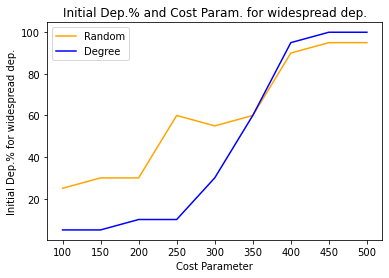

In [225]:
#普及状態に達した初期導入率とコストパラメータ
linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",'######start!######')

##setting##
ratelist=list(range(0,101,5))
costrangelist=list(range(100,550,50))

randomfulldependlist=[]
degreefulldependlist=[]
check=1000
Cbparam=0
Bbparam=0

for node in node_list:
    G.nodes[node]['Costparam']=(1+Cbparam*np.random.randn())*math.log(nx.degree(G)[node])
    G.nodes[node]['Brandparam']=Bbparam*np.random.randn()+1
    G.nodes[node]['nodepDamage']=G.nodes[node]['Brandparam']*G.nodes[node]['nodepDamage']
##end##

for costparam in costrangelist:
    linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",f'started {costparam}')
    for node in node_list:
        G.nodes[node]['Costfixed']=G.nodes[node]['Costparam']*costparam
    ##random
    for initialrate in ratelist:
        Final_Rate_at_Ccostp=inRate_toenddeprate('0',initialrate,costparam)+inRate_toenddeprate('0',initialrate,costparam)+inRate_toenddeprate('0',initialrate,costparam)+inRate_toenddeprate('0',initialrate,costparam)+inRate_toenddeprate('0',initialrate,costparam)
        if  Final_Rate_at_Ccostp/5>95:
            randomfulldependlist.append(initialrate)
            break

    ##degree
    for initialrate in ratelist:
        Final_Rate_at_Ccostp=inRate_toenddeprate('1',initialrate,costparam)
        if Final_Rate_at_Ccostp>95:
            degreefulldependlist.append(initialrate)
            break
            
fig = plt.figure()
plt.plot(costrangelist,randomfulldependlist,color='orange',label='Random')
plt.plot(costrangelist,degreefulldependlist,color='blue', label='Degree')
plt.title(f'Initial Dep.% and Cost Param. for widespread dep.')
plt.xlabel('Cost Parameter')
plt.ylabel('Initial Dep.% for widespread dep.')
plt.legend()
plt.show()
now=datetime.datetime.now()
fig.savefig(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}/I&C,{costrangelist[0]}~{costrangelist[-1]},{len(node_list)}at{now}.png')
with open(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}/I&C,{costrangelist[0]}~{costrangelist[-1]},{len(node_list)}at{now}.binaryfile', 'wb') as web:
    pickle.dump(randomfulldependlist+degreefulldependlist, web)


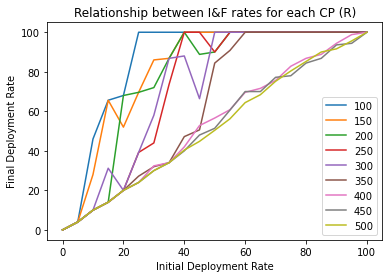

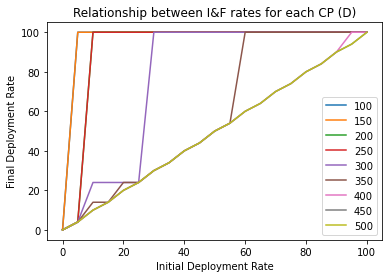

In [25]:
#各コストパラメータにおける，初期導入率と最終導入率の関係
linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",'######start!######')

##setting##
ratelist=list(range(0,101,5))
costrangelist=list(range(100,550,50))

randomfulldependlist=[]
degreefulldependlist=[]
check=1000
Cbparam=0
Bbparam=0

for node in node_list:
    G.nodes[node]['Costparam']=(1+Cbparam*np.random.randn())*math.log(nx.degree(G)[node])
    G.nodes[node]['Brandparam']=Bbparam*np.random.randn()+1
    G.nodes[node]['nodepDamage']=G.nodes[node]['Brandparam']*G.nodes[node]['nodepDamage']
##end##

for costparam in costrangelist:
    linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",f'started {costparam}')
    for node in node_list:
        G.nodes[node]['Costfixed']=G.nodes[node]['Costparam']*costparam
    ##random
    randomfulldependlist.append([(inRate_toenddeprate('0',initialrate,costparam)+inRate_toenddeprate('0',initialrate,costparam)+inRate_toenddeprate('0',initialrate,costparam)+inRate_toenddeprate('0',initialrate,costparam)+inRate_toenddeprate('0',initialrate,costparam))/5 for initialrate in ratelist])
    ##degree
    degreefulldependlist.append([inRate_toenddeprate('1',initialrate,costparam) for initialrate in ratelist])


fig = plt.figure()
for i in range(len(randomfulldependlist)):
    plt.plot(ratelist,randomfulldependlist[i],label=str(costrangelist[i]))
plt.title('Relationship between I&F rates for each CP (R)')
plt.xlabel('Initial Deployment Rate')
plt.ylabel('Final Deployment Rate')
plt.legend()
plt.show()
now=datetime.datetime.now()
fig.savefig(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}/C&IF,ran.,{costrangelist[0]}~{costrangelist[-1]},{len(node_list)}at{now}.png')
with open(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}/C&IF,ran.,{costrangelist[0]}~{costrangelist[-1]},{len(node_list)}at{now}.binaryfile', 'wb') as web:
    pickle.dump(randomfulldependlist, web)
    
fig = plt.figure()
for i in range(len(degreefulldependlist)):
    plt.plot(ratelist,degreefulldependlist[i],label=str(costrangelist[i]))
plt.title('Relationship between I&F rates for each CP (D)')
plt.xlabel('Initial Deployment Rate')
plt.ylabel('Final Deployment Rate')
plt.legend()
plt.show()
now=datetime.datetime.now()
fig.savefig(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}/C&IF,deg.,{costrangelist[0]}~{costrangelist[-1]},{len(node_list)}at{now}.png')
with open(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}/C&IF,deg.,{costrangelist[0]}~{costrangelist[-1]},{len(node_list)}at{now}.binaryfile', 'wb') as web:
    pickle.dump(degreefulldependlist, web)


In [ ]:
# 各コストパラメータにおける，初期導入率と最終導入率の関係
linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",'######start!######')

##setting##
ratelist=list(range(0,101,5))
costrangelist=list(range(100,550,50))
randomfulldependlist=[]
degreefulldependlist=[]
check=1000
##end##

for t in ['Random','Degree']:
  for c in costrangelist:
    cost=c
    datalist=[]
    check=1000

    if t=='Random':
      for j in ratelist:
        buff=0
        buff+=inRate_toenddeprate(t,j)+inRate_toenddeprate(t,j)+inRate_toenddeprate(t,j)+inRate_toenddeprate(t,j)+inRate_toenddeprate(t,j) #ある初期導入率出の最終導入率
        buff=buff/5                               #それを平均する
        datalist.append(buff)               #それをリストにアペンドする
        if buff>=95 and check>j:         #もしある初期導入率出の最終導入率が９５以上で、以前の値より初期導入率が小さければ
          randomfulldependlist.append(j)
          check=j

    check=1000

    if t=='Degree':
      for j in ratelist:
        buff=inRate_toenddeprate(t,j)
        datalist.append(buff)
        if buff==100 and check>j:
          degreefulldependlist.append(j)
          check=j
            

#     plt.plot(ratelist,datalist,label=c)
#     fig = plt.figure()
#     plt.title(f'{t},cost=250~550,node={len(node_list)}')
#     plt.xlabel('First Deployment Rate')
#     plt.ylabel('Final Deployment Rate')
    plt.plot(costrangelist,randomfulldependlist)
    plt.plot(costrangelist,degreefulldependlist)
    fig = plt.figure()
    plt.title(f'{t},cost=250~550,node={len(node_list)}')
    plt.xlabel('Cost Parameter')
    plt.ylabel('Initial Dep. rate for widespread Dep.')

    
    linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",f'plot completed! title={t},cost={c},node={len(node_list)}')
  plt.show()
  if not os.path.exists(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}')
    os.makedirs(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}')
  fig.savefig(f'/Users/odrag0n/Desktop/Dropbox/Data file/plots/{today}/IRTE,{t[0]},0-{c}.png')

linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",'finished')